In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from datasets import Dataset
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TFBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

2025-08-27 21:58:05.482995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756331885.852007      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756331885.960801      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

fake = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "Fake.csv"
)

true = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "True.csv"
)

print("Fake news sample:")
print(fake.head())

print("\nTrue news sample:")
print(true.head())


/tmp/ipykernel_36/2829289281.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  fake = kagglehub.load_dataset(
/tmp/ipykernel_36/2829289281.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  true = kagglehub.load_dataset(


Fake news sample:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

True news sample:
                                               title  \
0  As U.S. budget fight looms, Republicans flip

In [ ]:
def clean(df):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    RE_WSPACE = re.compile(r"\s+")
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-z0-9À-ž ]")   
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b")

    for i in range(len(df)):
        sentence = df.loc[i, 'all_text']

        sentence = re.sub(RE_TAGS, " ", sentence)
        sentence = re.sub(RE_ASCII, " ", sentence)
        sentence = re.sub(RE_SINGLECHAR, " ", sentence)
        sentence = re.sub(RE_WSPACE, " ", sentence)

        sentence = word_tokenize(sentence)
        sentence = [word.lower() for word in sentence]
        sentence = [word for word in sentence if word not in stop_words]
        # no lemmatization as bert does it anyways 
        #sentence = [lemmatizer.lemmatize(word) for word in sentence]

        df.loc[i, 'all_text'] = " ".join(sentence)

    return df


In [4]:
fake['label'] = 1
true['label'] = 0

In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [6]:
df = pd.concat([true, fake], ignore_index=True)
df['all_text'] = df['title'] + " " + df['text']
df = df.drop(columns = ['title' , 'text' , 'date' , 'subject'])

df.head()

,label,all_text
0,0,"As U.S. budget fight looms, Republicans flip t..."
1,0,U.S. military to accept transgender recruits o...
2,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,0,FBI Russia probe helped by Australian diplomat...
4,0,Trump wants Postal Service to charge 'much mor...


In [7]:
df  = clean(df)

In [8]:
texts = df['all_text'].astype(str).tolist()
labels = df['label'].tolist()

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

I0000 00:00:1756332019.714017      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756332019.714777      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'distilbert.transformer.layer.3.attention.q_lin.weight', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'vocab_transform.bias', 'distilbert.transformer.layer.3.ffn.lin2.bias', 'distilbert.transformer.layer.5.attention.out

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42
)

X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

train_masks = tf.cast(X_train != tokenizer.pad_token_id, dtype=tf.int32)
test_masks = tf.cast(X_test != tokenizer.pad_token_id, dtype=tf.int32)

In [11]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_train, 'attention_mask': train_masks}, y_train
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': X_test, 'attention_mask': test_masks}, y_test
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3,
    callbacks=[early_stopping]
)


Epoch 1/3


I0000 00:00:1756332255.308517     132 service.cc:148] XLA service 0x78ec1b521c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756332255.310310     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756332255.310329     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756332255.437368     132 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756332255.606058     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2245/2245 [==============================] - 1114s 473ms/step - loss: 0.0711 - accuracy: 0.9609 - val_loss: 0.0302 - val_accuracy: 0.9939
Epoch 2/3
2245/2245 [==============================] - 1054s 469ms/step - loss: 0.0149 - accuracy: 0.9975 - val_loss: 0.0208 - val_accuracy: 0.9968
Epoch 3/3
2245/2245 [==============================] - 1054s 469ms/step - loss: 0.0126 - accuracy: 0.9980 - val_loss: 0.0183 - val_accuracy: 0.9973


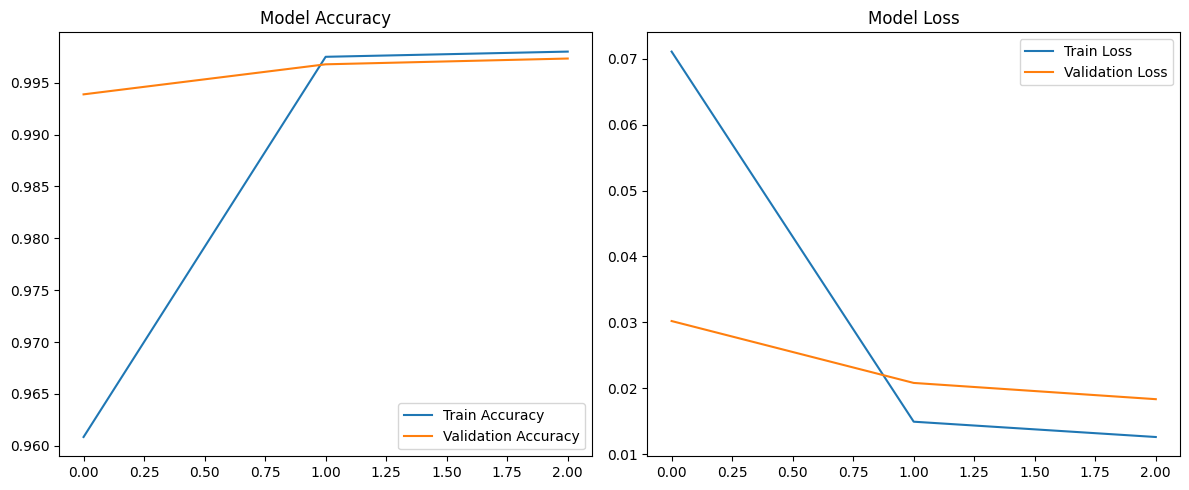

In [13]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

562/562 [==============================] - 83s 148ms/step - loss: 0.0183 - accuracy: 0.9973

Test Accuracy: 0.9973
Test Loss: 0.0183
562/562 [==============================] - 86s 146ms/step

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4330
        Real       1.00      1.00      1.00      4650

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



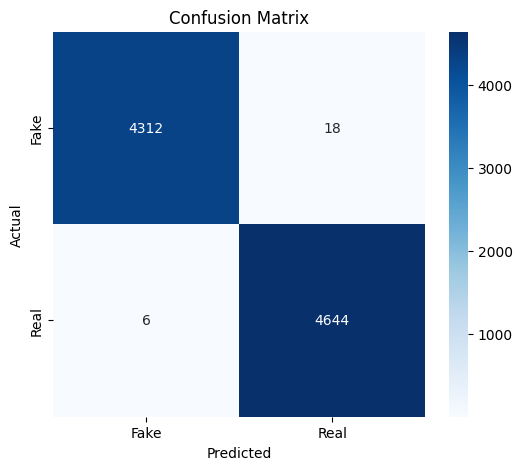

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

preds = model.predict(test_dataset).logits
y_pred = np.argmax(preds, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

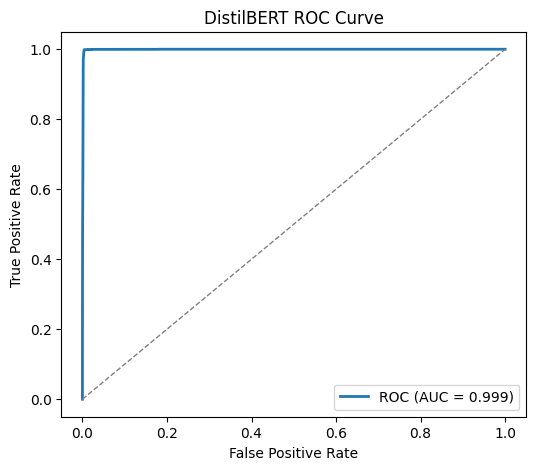

In [22]:
outputs = model.predict(test_dataset)
logits = outputs.logits if hasattr(outputs, "logits") else outputs
logits = np.asarray(logits)

if logits.ndim == 2 and logits.shape[1] == 1:
    y_prob = tf.nn.sigmoid(logits).numpy().ravel()
else:
    y_prob = tf.nn.softmax(logits, axis=1).numpy()[:, 1]

y_true = np.asarray(y_test).ravel()
assert len(y_prob) == len(y_true), "Mismatch: predictions and labels length must match"

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 5. Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', lw=2)
plt.plot([0,1], [0,1], '--', lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DistilBERT ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
model.save_pretrained("bert_finetuned_tf")
tokenizer.save_pretrained("bert_finetuned_tf")

('bert_finetuned_tf/tokenizer_config.json',
 'bert_finetuned_tf/special_tokens_map.json',
 'bert_finetuned_tf/vocab.txt',
 'bert_finetuned_tf/added_tokens.json')

In [32]:
import os
import zipfile
save_dir = "bert_finetuned_tf"
zip_filename = f"{save_dir}.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(save_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=save_dir)  
            zipf.write(file_path, arcname)